In [1]:
import requests
from requests import get
import os
import unicodedata
import re
import json

import acquire as a
import prepare as p

import pandas as pd # to handle the dataframe
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Acquire and Prepare functions with train, validate and test
df = a.get_data(query_url = False)
print(df.shape)
df = p.prepare_dataframe(df)
train, validate, test = p.split_data(df)
train.shape, validate.shape, test.shape

Getting file from URL...
Retrieved data from url!
Saved data to file!
(70932, 83)


((40311, 60), (6719, 60), (6719, 60))

In [3]:
train.head()

,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,...,printed_name,color_indicator,life_modifier,hand_modifier,content_warning,flavor_name,usd,is_foil,is_etched,is_glossy
39296,8e1e4b26-0a2b-4078-adb3-1f66315afcf5,Goblin Razerunners,en,2017-10-24,normal,True,highres_scan,{2}{R}{R},4.0,Creature — Goblin Warrior,...,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.11,False,False,False
30783,6f2fc246-2e95-456f-aa4e-97768c4f4bb4,Rites of Initiation,en,2001-10-01,normal,True,highres_scan,{R},1.0,Instant,...,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.25,True,False,False
26765,606206c7-1a8a-46f4-b368-cf18e02f3df8,Undying Flames,en,2005-06-03,normal,True,highres_scan,{4}{R}{R},6.0,Sorcery,...,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.30,True,False,False
8690,1f391555-4697-4492-9854-32393f473104,Bombard,en,2018-11-16,normal,True,highres_scan,{2}{R},3.0,Instant,...,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.05,False,False,False
25570,5c1f3f52-cb9b-4b2a-bb02-6175897ae76e,Our Market Research Shows That Players Like Re...,en,2004-11-19,normal,True,highres_scan,{1}{G}{G},3.0,Creature — Elemental,...,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.20,True,False,False


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40311 entries, 39296 to 2198
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                40311 non-null  object        
 1   name              40311 non-null  object        
 2   lang              40311 non-null  object        
 3   released_at       40311 non-null  datetime64[ns]
 4   layout            40311 non-null  object        
 5   highres_image     40311 non-null  bool          
 6   image_status      40311 non-null  object        
 7   mana_cost         40311 non-null  object        
 8   cmc               40311 non-null  float64       
 9   type_line         40311 non-null  object        
 10  oracle_text       40311 non-null  object        
 11  power             40311 non-null  object        
 12  toughness         40311 non-null  object        
 13  colors            40311 non-null  object        
 14  color_identity    4

# Hypothesis 1
- H0:The amount of cards created is not = to the artist value.
- HA:The amount of cards created is not = to the artist value.

In [5]:
# Rarity card count
df.rarity.value_counts()

common      20294
rare        16059
uncommon    14595
mythic       2554
special       247
Name: rarity, dtype: int64

In [6]:
train['usd'].value_counts()

0.10      1609
0.09      1301
0.08      1168
0.05      1165
0.06      1127
          ... 
15.95        1
445.00       1
19.94        1
38.90        1
61.97        1
Name: usd, Length: 2878, dtype: int64

<AxesSubplot:>

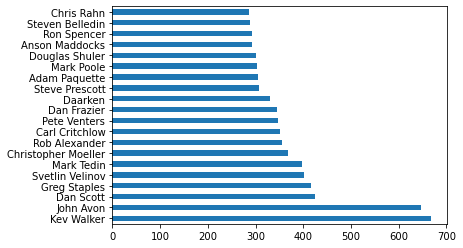

In [7]:
# Top 20 artist who created the most cards
train['artist'].value_counts()[:20].plot(kind='barh')

<AxesSubplot:>

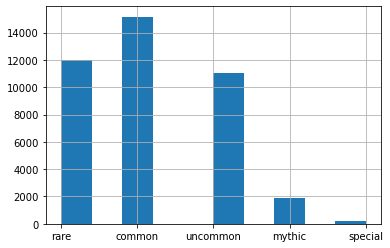

In [8]:
# Count of cards by rarity
train.rarity.hist()

In [9]:
# filter out lands and tokens 

train = train.loc[train['rarity'].isin(['common', 'uncommon', 'rare', 
                                        'mythic', 'special', 'bonus'])]
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40311 entries, 39296 to 2198
Columns: 60 entries, id to is_glossy
dtypes: bool(17), datetime64[ns](1), float64(6), object(36)
memory usage: 14.2+ MB


This gives 53199 cards.

In [10]:
# show only data from the selected columns
df2 = train[['name', 'set_type', 'artist', 'rarity', 'usd', 'collector_number']]


In [30]:
# show only data from top 40 cards by price
df3 = df2.loc[:,'name':'collector_number'].sort_values(by=['usd'], ascending=False,)[:20]

In [31]:
df3

,name,set_type,artist,rarity,usd,collector_number
12737,Ancestral Recall,core,Mark Poole,rare,6999.99,48
47092,Tropical Island,core,Jesper Myrfors,rare,6000.00,283
497,Timetwister,core,Mark Tedin,rare,5732.99,85
27959,The Tabernacle at Pendrell Vale,expansion,Nicola Leonard,rare,3888.00,307
31249,Mox Jet,core,Dan Frazier,rare,3099.99,263
48249,Time Walk,core,Amy Weber,rare,2999.00,84
55578,Mox Pearl,core,Dan Frazier,rare,2879.99,264
70206,Copy Artifact,core,Amy Weber,rare,2849.99,53
5467,Mishra's Workshop,expansion,Kaja Foglio,rare,2700.00,81
13853,Juzám Djinn,expansion,Mark Tedin,rare,2499.94,29


In [32]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 12737 to 39052
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              20 non-null     object 
 1   set_type          20 non-null     object 
 2   artist            20 non-null     object 
 3   rarity            20 non-null     object 
 4   usd               20 non-null     float64
 5   collector_number  20 non-null     object 
dtypes: float64(1), object(5)
memory usage: 1.1+ KB


### Visualization

Used the top 100 cards based on value to chart results.

<AxesSubplot:>

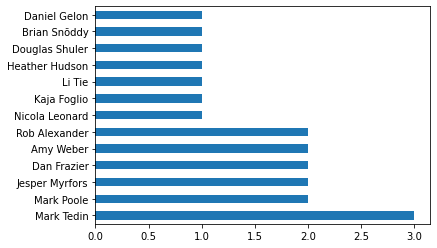

In [33]:
# Plot top 100 cards and artist by amount of cards created
df3['artist'].value_counts().plot(kind='barh')

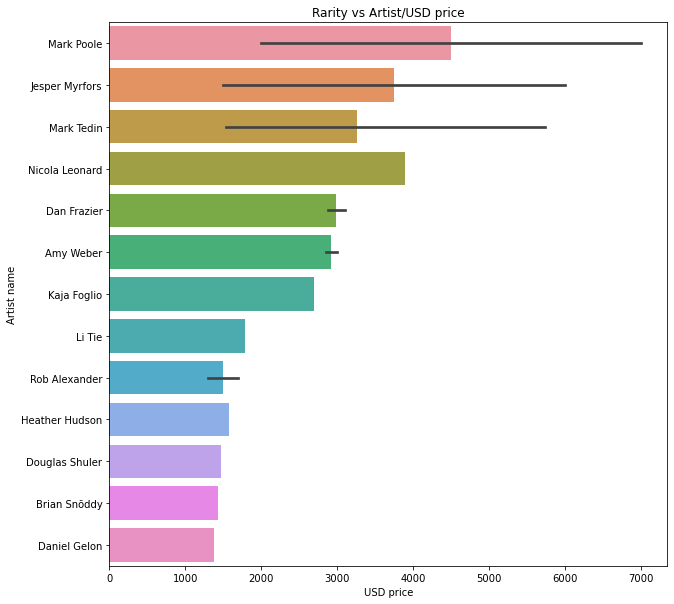

In [34]:
# Bar plor to show Artist and USD price, for top artist
def vis_artist_by_usd(df3):
    plt.figure(figsize=(10,10))
    sns.barplot(data=df3, x='usd', y='artist')
    plt.title('Rarity vs Artist/USD price')
    plt.xlabel('USD price')
    plt.ylabel('Artist name')
    plt.show()

vis_artist_by_usd(df3)


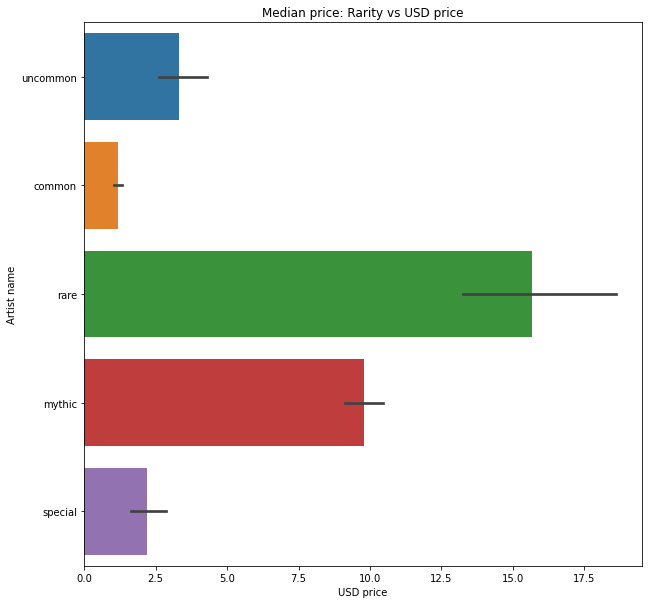

In [35]:
# Median price for all cards based on Rarity and USD price
def vis_rarity_by_usd(df):
    plt.figure(figsize=(10,10))
    sns.barplot(data=df, x='usd', y='rarity')
    plt.title('Median price: Rarity vs USD price')
    plt.xlabel('USD price')
    plt.ylabel('Artist name')
    plt.show()

vis_rarity_by_usd(df)


In [36]:
df.rarity.value_counts()


common      20294
rare        16059
uncommon    14595
mythic       2554
special       247
Name: rarity, dtype: int64

### Key takeaway

- The amount of cards created is not = to the artist value.

- In the charts artist Jon Avon created the most cards but the artist Christopher Rush created the most expensive card(Black Lotus)



# Hypothesis 2
- H0: artist and rarity of cards is = to price 
- HA: artist and rarity of cards is not = to price

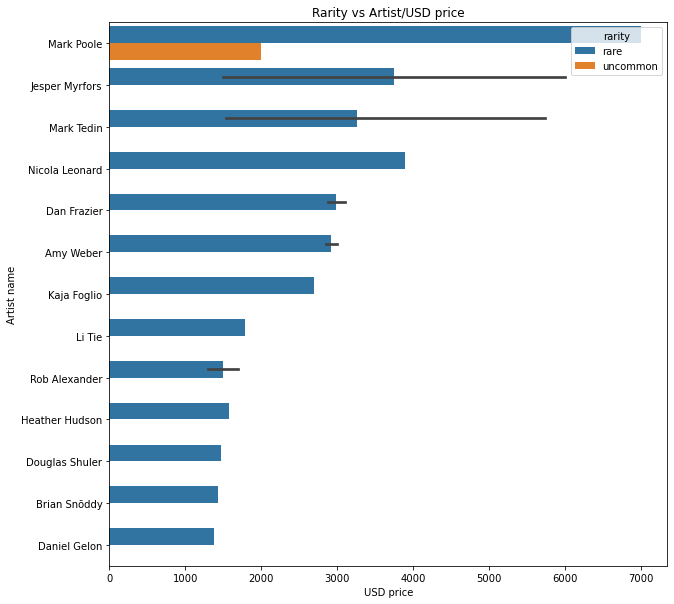

In [37]:
# Bar plot to show Artist, USD price and rarity of cards for top artist
def vis_artist_by_usd(df3):
    plt.figure(figsize=(10,10))
    sns.barplot(data=df3, x='usd', y='artist', hue='rarity')
    plt.title('Rarity vs Artist/USD price')
    plt.xlabel('USD price')
    plt.ylabel('Artist name')
    plt.show()

vis_artist_by_usd(df3)

### Key takeaway

- The artist and rarity of cards is not = to price

- In the charts only one none rare card is in the high value price range.


# Hypothesis 3
- H0: set_type and rarity of cards is = to price 
- HA: set_type and rarity of cards is not = to price

In [38]:
# Cards value count to set_types
df.set_type.value_counts()

expansion           22211
core                 6780
masters              5620
commander            5475
draft_innovation     3910
duel_deck            1793
memorabilia          1473
promo                1434
box                  1341
token                 865
funny                 834
starter               820
planechase            645
archenemy             324
masterpiece           156
vanguard               28
spellbook              24
arsenal                16
Name: set_type, dtype: int64

<AxesSubplot:xlabel='count', ylabel='set_type'>

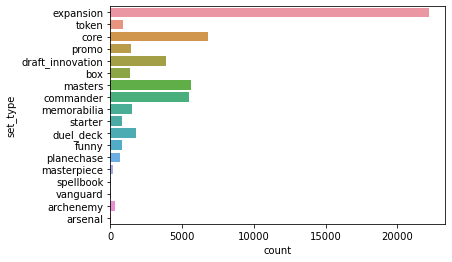

In [39]:
# Most expensive cards by set_type
sns.countplot(data= df, y='set_type')

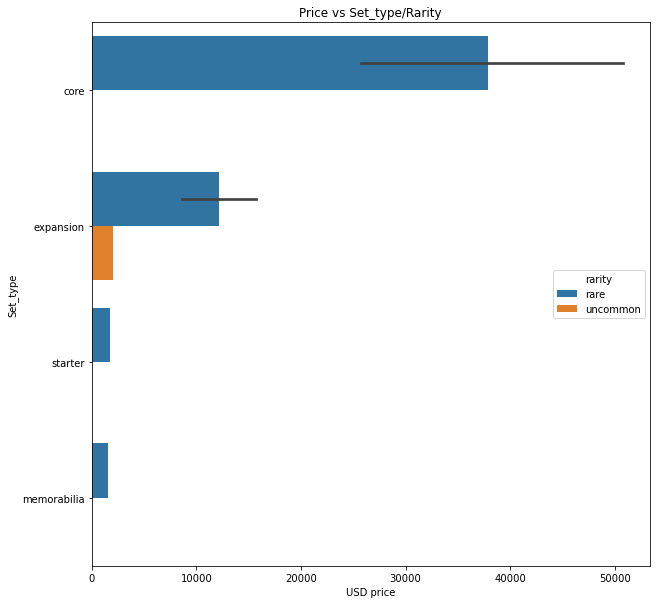

In [40]:
# top 100 cards: Set_type and Rarity 
def usd_rarity_set_type_total(df3):
    plt.figure(figsize=(10,10))
    sns.barplot(data=df3, x='usd', y='set_type', hue='rarity', estimator=sum)
    plt.title('Price vs Set_type/Rarity')
    plt.xlabel('USD price')
    plt.ylabel('Set_type')
    plt.show()

usd_rarity_set_type_total(df3)

### Key takeaway

- Rare cards are the most expensive regardless of set_type

- In the charts there are only a few none rare cards in the top 100 high value price range.



Hypothesis 4
- Is there a relationship between collector number and usd?

In [41]:
# Amount of cards collected by top collectors.
train['collector_number'].value_counts()

3          245
2          240
5          233
1          231
6          226
          ... 
T3           1
1669         1
jk262sb      1
57p          1
117s         1
Name: collector_number, Length: 2848, dtype: int64

<AxesSubplot:>

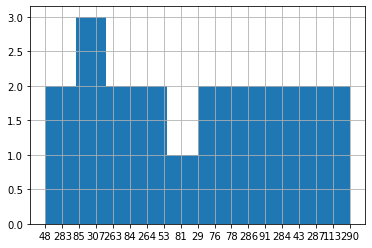

In [42]:
df3.collector_number.hist()

<AxesSubplot:xlabel='count', ylabel='collector_number'>

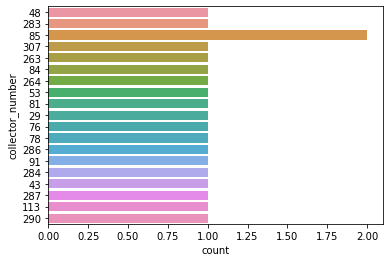

In [48]:
sns.countplot(data= df3, y='collector_number')

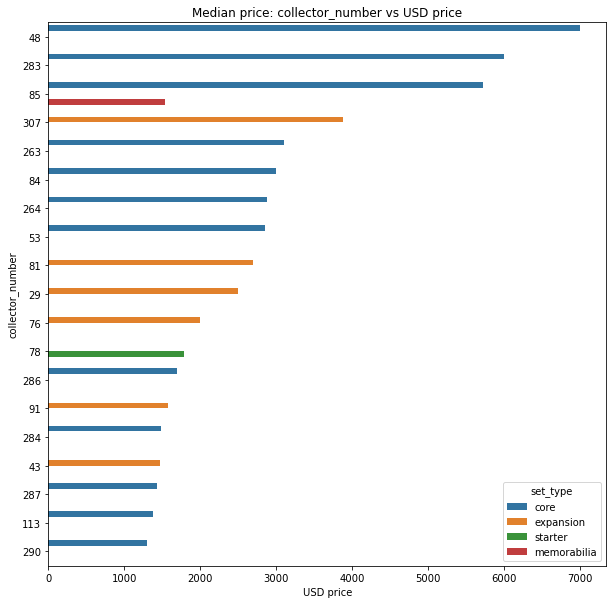

In [46]:
# Median price for all cards based on Rarity and USD price
def vis_rarity_by_usd(df3):
    plt.figure(figsize=(10,10))
    sns.barplot(data=df3, x='usd', y='collector_number', hue='set_type')
    plt.title('Median price: collector_number vs USD price')
    plt.xlabel('USD price')
    plt.ylabel('collector_number')
    plt.show()

vis_rarity_by_usd(df3)

Takeaway:
More information on the collecters would be need to complete this H0. But from this data it seems that the top collecters do seem to collects mostly core and expansion cards.